# Tutorial: DenseCRF for segmentation task

## Reference
- Paper: https://arxiv.org/abs/1210.5644
- Pydensecrf: https://github.com/lucasb-eyer/pydensecrf.git
- FCN Model: https://pytorch.org/hub/pytorch_vision_fcn_resnet101/


## 1. Problem Statement
- Segmentation task는 object 중점의 robust 하고 global한 feature 추출을 목적으로하는 classification / detection task와 다르게 pixel level의 prediction을 수행하야 하므로, detail한 feature 추출이 필요하다.

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
# or
# model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=True)
model.eval()

In [ ]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]

In [ ]:
import numpy as np

VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
    "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "potted plant", "sheep", "sofa", "train", "tv/monitor",
]

VOC_COLORMAP = np.array([
    [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128], [0, 0, 0],
])

VOC_NUM_CLASSES = 21

In [ ]:
import matplotlib.pylab as plt

def draw_voc_segmentation_result(img, pred):

    plt.figure(figsize=(20,20))

    #img = img.transpose(1, 2, 0)

    pred = pred.argmax(0).squeeze(0)

    print(pred.shape)
    pred = pred.data.cpu().numpy()
    bins = np.bincount(pred.flatten())
    label_value = np.nonzero(bins)[0]

    pred_mask = np.zeros(shape=(pred.shape[0],pred.shape[1] , 3), dtype='uint8')

    for n_class in range(VOC_NUM_CLASSES):
      pred_mask[np.where(pred>n_class)] = VOC_COLORMAP[n_class,:]

    plt.subplot(1,2,1)
    plt.title('Input Image', fontsize=16)
    plt.axis('off')
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.title('Predict', fontsize=16)
    plt.axis('off')
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.imshow(pred_mask)

    plt_handlers = []
    plt_titles = []
    for idx in label_value:

        if idx != 0:
          fc = VOC_COLORMAP[idx-1].astype('float')/255
          p = plt.Rectangle((0, 0), 1, 1, color=fc)
        
          plt_handlers.append(p)
          plt_titles.append('{value}: {name}'.format(value=idx, name=VOC_CLASSES[idx]))
        
    plt.legend(plt_handlers, plt_titles, loc='lower right', framealpha=.5)  

torch.Size([1026, 1282])


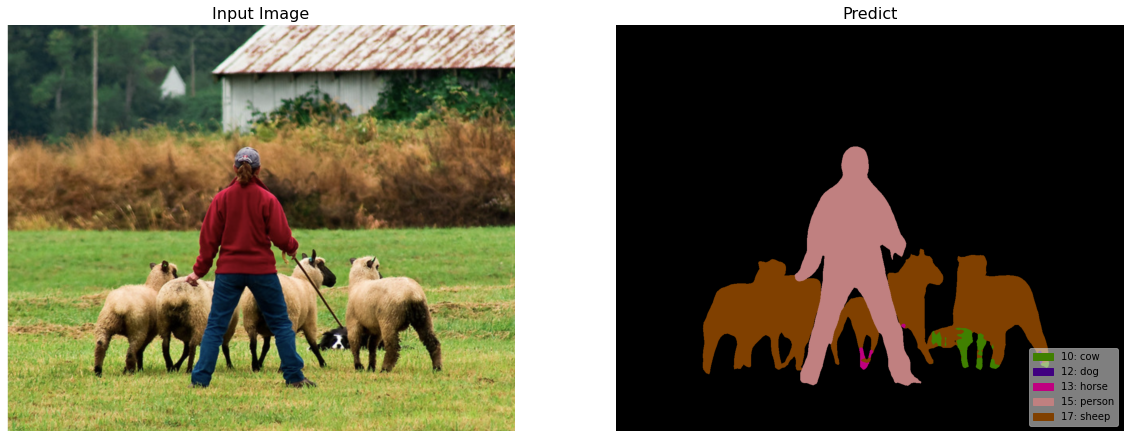

In [ ]:
input_np = Image.fromarray(np.uint8(input_image))

draw_voc_segmentation_result(input_np, output)

- FCN, DeepLab과 같이 feature map을 upsample이 포함된 network의 경우 정교한 segmentation 결과를 얻는 것은 한계가 있다. 이를 보완하기 위해 probabilistic graphical models을 이용한 post-processing을 적용할 수 있다.
    
- 본 article에서는 segmentation task에서 널리 활용되는 Conditional Random Field를 이용한 post-processing 과정을 다룬다.


## 2. Conditional Random Field

- CRF는 Markov random field의 일종으로 sequential labeling 문제에서 Recurrent Neural Network (RNN) 등의 deep learning 계열 알고리즘이 이용되기 이전에 널리 사용되었다.
- Sequence data $x$ 에 가장 적합한 sequence response $y$를 찾는 softmax regression(classifier) 의 일종으로, 입력 $x$가 주어졌을 때, label $y$에 속할 확률(posterior probability)을 최대로 만드는 최적의 output  $y^*$를 찾는 최적화 문제라 할 수 있다.
    
    $$
    y^*=\arg\max_{y}P\left(y\middle| x\right)
    $$
    
- Label의 probability를 Gibbs distribution으로 표현하면,
    
    $$
    P(\mathbf{y}|\mathbf{x})=\frac{1}{Z(\mathbf{x})}\exp \left(-\sum_{c \in \mathcal{C}_{\mathcal{G}}} \phi(\mathbf{y}_c|\mathbf{x})\ \right)
    $$
    
    여기서 $\mathcal{G}$는 label의 graph, cliques의 집합 $\mathcal{C}_{\mathcal{G}}$의 각 clique $c$는 potential $\phi_c$를 가진다. 
    
    Label $\mathbf{x}\in\mathcal{L}^N$에 대한 Gibbs energy는 다음과 같이 나타낼 수 있다.
    
    $$
    E(\mathbf{y}|\mathbf{x})=\sum_{c \in \mathcal{C}_{\mathcal{G}}}\phi_c(\mathbf{y}_c|\mathbf{x})
    $$
    
    이를 이용하면 label에 대한 random field를 구하기 위한 확률 $P(\mathbf{y|\mathbf{x}})$ 최대화 문제를 Energy 최소화 문제로 표현할 수 있다.

## 3. CRF for Image Segmentation

![Source: A. Arnab, et al., “Conditional Random Fields Meet Deep Neural Networks for Semantic](pic/crf/img.png)
    
Source: A. Arnab, et al., “Conditional Random Fields Meet Deep Neural Networks for Semantic

- Segmentation task의 경우 주어진 image의 각 pixel (observation)과 이에 대응되는 label $y$를 다음과 같이 modeling 할 수 있다.
    - 입력 영상(observation): 변수 $\{I_1,...,I_N\}$으로 구성된 random field $I$
    - Segmentation map (pixel level label): domain으로 label $\mathcal{L}=\{l_1, l_2, ..., l_k\}$을 가지는 변수 $\{X_1,...,X_N\}$으로 구성된 random field $X$
- 보편적으로 semantic segmentation의 경우 다음 가정이 유효하므로,
    
    (1) 어떤 pixel이 어떤 label로 판별 되면, 주변에 있는 픽셀 또한 같은 label을 가질 가능이 높음.
    
    (2) 두 pixel이 유사한 값을 가진다면 같은 label을 가질 가능성이 높음
    
- CRF의 Potential function을 다음과 같이 Unary potential과 pairwise potential로 표현한다. 
(논문과 동일하게 $\phi(\mathbf{x}|\mathbf{I})$를 $\psi(\mathbf{x})$로 간단히 표현)
    
    $$
    E(\mathbf{x})=\sum_{i}\psi_u(x_i)+\sum_{i}\sum_{j\in \partial i}\psi_p(x_i,x_j)
    $$
    
    ![Untitled](pic/crf/Untitled.png)
    

### (1) **Unary potential $\theta_i$**

- 픽셀 $i$에 label이 할당될 확률이며, CNN에 의해 계산된다.

$$
\psi_i(x_i)=-\log P(x_i)
$$

In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-svl2ve0c
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-svl2ve0c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2778815 sha256=3124454c5055ac68d99787ac4f5ddf7d8ae66ad294a7c16d67f8bc4e0857b980
  Stored in directory: /tmp/pip-ephem-wheel-cache-b04csu4b/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf


In [ ]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary, unary_from_softmax

import skimage.io as io

In [ ]:
image = np.asarray(input_image)

dcrf_model = dcrf.DenseCRF(image.shape[0] * image.shape[1], VOC_NUM_CLASSES)

In [ ]:
if torch.cuda.is_available():
    output_logit = output.to('cpu')

softmax = torch.nn.functional.softmax(output_logit, dim=0).numpy()

unary = unary_from_softmax(softmax)
unary = np.ascontiguousarray(unary)
dcrf_model.setUnaryEnergy(unary)


### (2) **Pairwise potential $\theta_{i,j}$**

$$
\begin{aligned}
    \psi_{p}(x_i,x_j)&=\mu(x_i,x_j) \cdot \sum_{m=1}^{K}w^{(m)}k^{(m)}(\mathbf{f}_i, \mathbf{f}_j) \\
    &where \ k^{(m)}(\mathbf{f}_i, \mathbf{f}_j)=\exp\left(-\frac{1}{m}(\mathbf{f}_i, \mathbf{f}_j)^{T}\Lambda^{(m)} (\mathbf{f}_i, \mathbf{f}_j)\right)
\end{aligned} 
$$

- $k^{(m)}$은 Gaussian kernel로 $\mathbf{f}_i, \mathbf{f}_j$는 pixel $i$와 $j$에서의 feature vector이며, $\mu()$는 $x_i\neq x_j$
 인 경우 1 , 그 외의 경우 0값을 가지는 label compatibility 함수이다.
- 영상 속의 object가 일반적으로 연속적인 pixel들로 표현되므로, pixel $i$와 $j$가 공간적으로 가까이 있거나, 비슷한 모습을 보이는 경우 높아지도록 appearance kernel과 smoothness kernel로 구성된 kernel을 적용한다.

$$
\begin{aligned}
    k^{(m)}(\mathbf{f}_i, \mathbf{f}_i)=\left[w_1 \exp\left( -\frac{||p_i-p_j||^2}{2\sigma_{\alpha}^2} -\frac{||I_i-I_j||^2}{2\sigma_{\beta}^2}\right) +w_2 \exp\left( -\frac{||p_i-p_j||^2}{2\sigma_{\gamma}^2} \right)\right]
\end{aligned}
$$

- 첫 번째 커널(appearance kernel)의 경우 position $p_i$와 $p_j$에서의 color vector $I_i$와 $I_j$에 대해 정의되며 공간적으로 유사한 위치에 있고 유사한 intensity를 가지면 큰 값을 가지게 된다.
- 두 번째 커널(smoothness kernel)의 경우 pixel positions $p$에 대해 정의되며, 고립된 작은 영역을 제거하는 효과를 가진다.
- 하이퍼 파라미터인  $\sigma_{\alpha}$, $\sigma_{\beta}$, $\sigma_{\gamma}$가 가우시안 커널의 스케일을 조절할 수 있다.

In [ ]:
image = np.asarray(input_image)

feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

dcrf_model.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                   img=image, chdim=2)

dcrf_model.addPairwiseEnergy(feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)

## 4. **Fully Connected CRF for semantic segmentation**

- 인접한 화소의 pairwise potential을 이용한 CRF model은 모든 detail 표현하는데 한계가 존재하기 때문에 모든 pixel에 대해 정의한 pairwise potential를 적용하여 성능을 개선한다.
- 하지만 모든 node(pixel)과 연결되어 있는 pairwise potential을 적용한 CRF model의 propability$P(\mathbf{X}|\mathbf{I})$를 추정하기 위해  Markov chain Monte Carlo (MCMC) inference를 적용하는 경우 연산량 문제가 발생한다.
    
    ![Untitled](pic/crf/Untitled1.png)
    
    source: [http://swoh.web.engr.illinois.edu/courses/IE598/handout/fall2016_slide15.pdf](http://swoh.web.engr.illinois.edu/courses/IE598/handout/fall2016_slide15.pdf)
    
- 이를 해결하기 위해 Variational Inference의 아이디어를 활용한 Mean Field Approximation을 적용한다. ([https://jaejunyoo.blogspot.com/2017/04/auto-encoding-variational-bayes-vae-2.html](https://jaejunyoo.blogspot.com/2017/04/auto-encoding-variational-bayes-vae-2.html))

### (1) Mean Field Approximation

- 계산이 복잡한 Posterior distribution $P(\mathbf{x})$를 independent한 component로 구성된 marginals distribution $Q(\mathbf{x})=\prod_iQ_i(X_i)$으로 근사화한다.
- 이때 구하고자 하는 posterior와 유사하도록 최소의 KL-divergence $\mathbf{D}_{\text{KL}}(Q||P)$를 같는 distribution $Q$를 찾는다.
- Fully Connected CRFs model에서 KL-divergence를 최소화 하기 위해 다음과 같은 iterative update equation을 적용한다.

$$
Q_i(x_i=l)=\frac{1}{Z_i}\exp\left\{-\psi_u(x_i)-\sum_{l' \in L} \mu(l.l')\sum_{m=1}^{K} w^{m} \sum_{i \neq i}k^{(m)}(f_i,f_j)Q_j(l') \right\}
$$

- 각 과정의 연산을 Massage passing, compatibility transform 그리고 local update step으로 구분할 수 있다.
    
    ![Untitled](pic/crf/Untitled2.png)
    

- 여기서 Message passing 과정의 복잡도는 $O(N^2)$으로 나타나므로 이를 근사화하여 연산량을 추가로 감소시킨다.

### (2) Efficient Message Passing

- 다음과 같이 표현되는 massage pass step을

$$
Q_i(x_i=l)=\frac{1}{Z_i}\exp\left\{-\psi_u(x_i)-\sum_{l' \in L} \mu(l.l')\sum_{m=1}^{K} w^{m} \widetilde{Q}_i^{(m)}(l) \right\}
$$

$$
\widetilde{Q}_i^{(m)}(l)=\sum_{j \neq i} k^{m}(f_i,f_j)Q_j(l')
$$

- feature space에서의 Gaussian kernel $G^{(m)}_{\Lambda}$와의 convolution 연산으로 표현할 수 있다.
    
    $$
    \widetilde{Q}_i^{(m)}(l)=\sum_{j \neq i} k^{m}(f_i,f_j)Q_j(l')=\left[G^{(m)}_{\Lambda}\otimes Q(l)\right](\mathbf{f_i})-Q_i(l)
    $$
    
    Gaussian Kernel과의 convolution 연산은 low-pass filter와 같은 smooth 효과를 나타낸다.

- Sampling 이론에 따르면 간격이 filter의 표준편차에 비례하는 sample 집합을 이용하여 신호를 복원(reconstruct)할 수 있으므로,  downsampling된 $Q(l)$을 이용 convolution을 수행한 후 다시 upsampling을 통해 신호를 복원할 수 있다.
    
    [https://cs.brown.edu/courses/cs129/2012/lectures/bf_course_Brown_Oct2012.pdf](https://cs.brown.edu/courses/cs129/2012/lectures/bf_course_Brown_Oct2012.pdf)
    
- 이 근사화를 통해 massage passing 과정의 복잡도를 $O(N)$으로 개선할 수 있다.
![Untitled](pic/crf/Untitled4.png)

KL-divergence at 0: -15814076.9236994
torch.Size([1026, 1282])
KL-divergence at 1: -16284520.772303186
torch.Size([1026, 1282])
KL-divergence at 2: -16329508.62152704
torch.Size([1026, 1282])
KL-divergence at 3: -16353090.822831595
torch.Size([1026, 1282])
KL-divergence at 4: -16359014.318705484
torch.Size([1026, 1282])


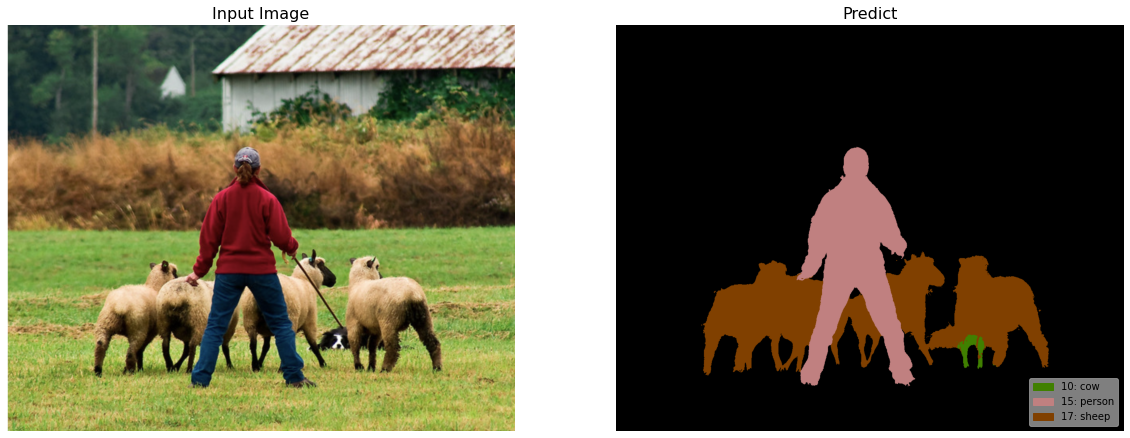

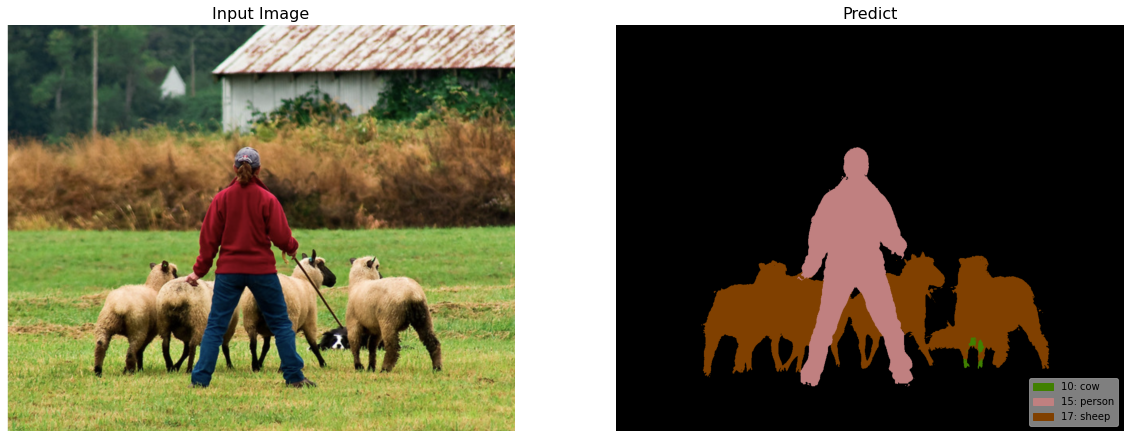

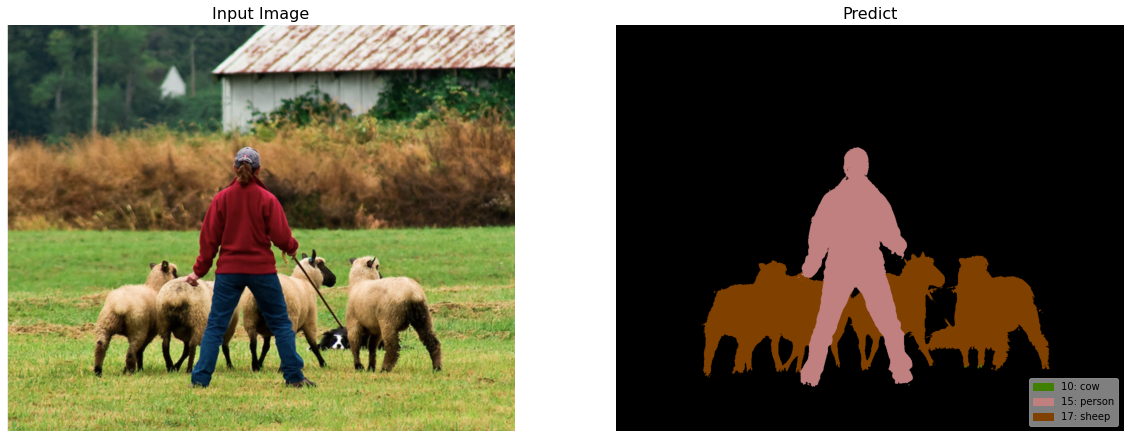

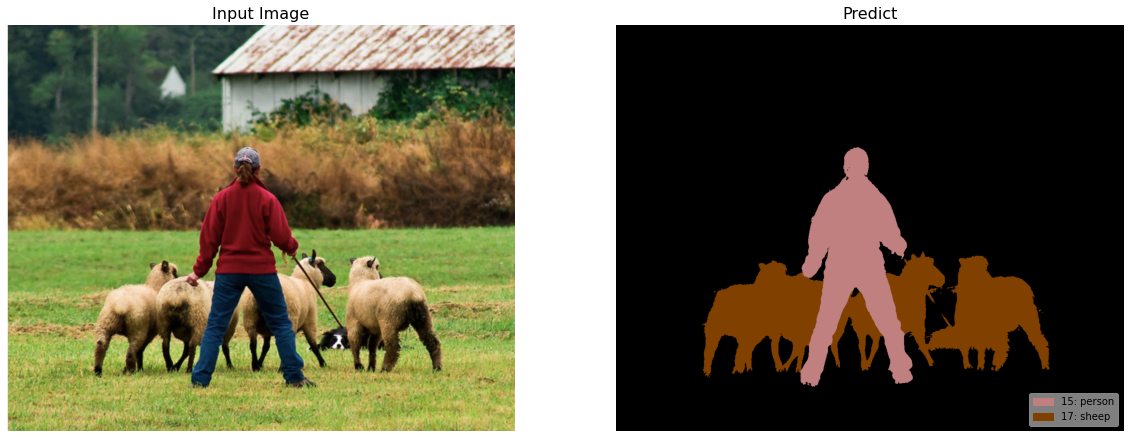

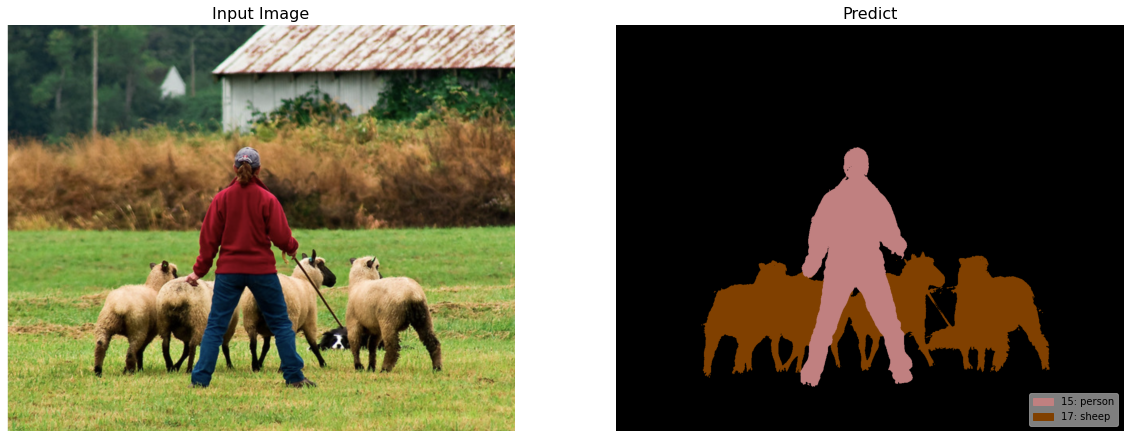

In [ ]:
#Q = d.inference(5)
Q, tmp1, tmp2 = dcrf_model.startInference()
for i in range(5):
    print("KL-divergence at {}: {}".format(i, dcrf_model.klDivergence(Q)))
    dcrf_model.stepInference(Q, tmp1, tmp2)

    res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))
    output_tensor = torch.from_numpy(res)
    output_tensor = torch.nn.functional.one_hot(output_tensor, num_classes =VOC_NUM_CLASSES).permute(2, 0, 1)
    draw_voc_segmentation_result(input_np, output_tensor)